In [5]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, constants as cnst, u_arrays, u_darrays
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.io.shapereader as shapereader
import pickle as pkl

coast = shapereader.natural_earth(resolution='110m',
                                  category='physical',
                                  name='coastline')

countries = shapereader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [9]:
MREGIONS = {'WAf' : [[-15,25,6,19], 'spac', 0], # last is hourly offset to UCT # 12    # [-18,25,4,25]
 'SAf' : [[20,35, -35,-15], 'spac', 2], # 10
 'india' : [[70,90, 5,30], 'asia', 5], # 7
 'china' : [[105,115,25,40], 'asia', 8 ], # 4
 'australia' : [[120,140,-23, -11], 'asia', 9], # 3
 'sub_SA' : [[-68,-47, -40, -20.5], 'spac', -4] , # 16
 'trop_SA' : [[-75, -50, -20, -5], 'spac', -5], # 17
 'GPlains' : [[-100,-90,32,47], 'nam', -6] # # 18

}


REGION='WAf'
h = 17

In [10]:
print(REGION)
path = cnst.network_data + 'data/GLOBAL_MCS/save_composites/'

for y in np.arange(2012, 2020):
    msg = pkl.load(
        open('/home/ck/DIR/cornkle/data/GLOBAL_MCS/save_files/'+REGION+'_noinit__mcs_tracks_extc_'+str(y)+'0101_'+str(y)+'1231.p', "rb"))
    hour = h

    # file = cnst.MCS_POINTS_DOM
    # msg = xr.open_dataarray(file)
    # msg = msg[(msg['time.hour'] == h) & (msg['time.minute'] == 0) & (
    #         msg['time.year'] == y) & (msg['time.month'] >= 6)]
    domain = (MREGIONS[REGION])[0]
    m1 = 6
    m2 = 9
    lontag = 'meanlon'
    lattag = 'meanlat'

    for k in msg.keys():

        msg[k] = np.array(msg[k])

    # inmask = (msg[lontag]>=domain[0])&(msg[lontag]<=domain[1])&(msg[lattag]>=domain[2])\
    #        &(msg[lattag]<=domain[3]) & (msg['hour'] == h) & (msg['mcs_status'] >= 0) & (msg['pf_landfrac'] > 0.8)  & (msg['month']>=m1) & (msg['month']<=m2)
    # if (np.sum(inmask) == 0) & (REGION in ['GPlains']):
    #     inmask = (msg[lontag]>=domain[0])&(msg[lontag]<=domain[1])&(msg[lattag]>=domain[2])\
    #        &(msg[lattag]<=domain[3]) & (msg['hour'] == h) & (msg['mcs_status'] >= 0)


    inmask = (msg[lontag] >= domain[0]) & (msg[lontag] <= domain[1]) & (msg[lattag] >= domain[2]) \
             & (msg[lattag] <= domain[3]) &  (msg['tracktime'] >= 4) & (msg['tracktime'] <= 8) & (msg['ccs_area'] >= 5000) & (msg['hour'] == h)  & (
                         msg['pf_landfrac'] > 0.9)  & (msg['month']>=m1) & (msg['month']<=m2)    #& (msg['pf_mcsstatus'] > 0)  (msg['hour'] >= h-1) & (msg['hour'] <= h+1)

    if (np.sum(inmask) == 0) & (REGION in ['GPlains']):
        inmask = (msg[lontag] >= domain[0]) & (msg[lontag] <= domain[1]) & (msg[lattag] >= domain[2]) \
                 & (msg[lattag] <= domain[3]) & (msg['hour'] >= h - 1) & (msg['hour'] <= h + 1) & (
                             msg['pf_mcsstatus'] > 0) & (msg['month']>=m1) & (msg['month']<=m2)

    #msc_status > 0 : MCS  = (-32C over 40000km2)
    # pf_landfrac > 0.8: 80% of rain fields over land

    mask = np.where(inmask)
    #ipdb.set_trace()
    for k in msg.keys():
        msg[k] = (msg[k])[mask]

    msg['date'] = []
    msg['day'] = []
    for yi, k in enumerate(msg['base_time']):
        bbt = pd.to_datetime(k)

        msg['date'].append(bbt.replace(hour=0, minute=0))
        msg['day'].append(bbt.day)
    msg['date'] = np.array(msg['date'])
    msg['day'] = np.array(msg['day'])

WAf


In [17]:
dic = {}
for k in ['tracktime', 'month', 'hour', 'date', 'pf_lon', 'pf_lat', 'meanlat', 'meanlon']:
    if 'pf' in k:
        pfl=[]
        for dd in msg[k]:
            pfl.append(dd[0]) 
        dic[k] = np.array(pfl)
    else:
        dic[k] = msg[k]
    print(len(dic[k]))

194
194
194
194
194
194
194
194


In [64]:
tab= pd.DataFrame.from_dict(dic)

In [65]:
print(tab.meanlon.max(), tab.meanlon.min(), tab.meanlat.max(), tab.meanlat.min())

24.96361541748047 -14.282482147216797 18.84637451171875 6.031939506530762


In [66]:
box = [-2,0,10,15]
np.sum((tab.meanlon>box[0]) & (tab.meanlon<box[1]) & (tab.meanlat>box[2]) & (tab.meanlat<box[3]))

1

In [69]:
tab = tab.loc[(tab.meanlon>box[0]) & (tab.meanlon<box[1]) & (tab.meanlat>box[2]) & (tab.meanlat<box[3])]

In [70]:
tab['time'] = tab['date']

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [71]:
tab

tracktime  month  hour       date    pf_lon     pf_lat    meanlat  \
91        8.0      8    17 2019-08-05 -1.237971  13.888556  14.337375   

     meanlon       time  
91 -1.396349 2019-08-05

In [72]:
def cut_kernel(xpos, ypos, arr, date, lon, lat):

    #AMSRE 0.25 degrees ~ 27.5 km
    dist = 11

    kernel = u_arrays.cut_kernel(arr,xpos, ypos,dist)


    # if (np.sum(np.isfinite(kernel)) < 0.10 * kernel.size):
    #     return

    kernel3 = kernel - np.nanmean(kernel)

    cnt = np.zeros_like(kernel)
    cnt[np.isfinite(kernel)] = 1

    if kernel.shape != (dist*2+1, dist*2+1):
        return None

    return kernel, kernel3, cnt

In [88]:
def run(shift):

    kernel2_list = []
    kernel3_list = []
    cnt_list = []
    
    for date in tab.time:


        single = tab[tab.time==date]

        dt = pd.to_datetime(date)
        daystring = str(abs(shift))
        dayd = pd.Timedelta(daystring + 'days')
        if shift <= -1:
            dt = dt - dayd
        if shift >=0:
            dt = dt + dayd
        
        #ipdb.set_trace()
        fdate = str(dt.year) + str(dt.month).zfill(2) + str(dt.day).zfill(2)
        
        fpath = cnst.lmcs_drive + 'AMSR2/daily/25km/day_anom_v2/'

        try:

            lsta = xr.open_dataset(fpath + 'amsr2_25km_anom' + fdate + '.nc') #sma  #'AMSR_L3_LPRMv05_A_'

        except:
            try:
                lsta = xr.open_dataset(fpath + 'amsr2_25km_anom_' + fdate + '.nc')
                #print('AMSR night')
            except:
                continue

        lsta = lsta.sel(lon=slice(-19, 15), lat=slice(5, 25))    
        lsta = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day))


        lsta_da = lsta['soil_moisture_c1'].squeeze()
    #     booleans = np.zeros_like(lsta_da.values) * np.nan
    #     booleans[lsta_da.values>4] = 1
    #     booleans[lsta_da.values<-4] = -1

        #lsta_da.values = booleans


    #     point = lsta_da.sel(lat=single.com_lat.values, lon=single.com_lon.values, method='nearest')
    #     if np.isnan(point.values):
    #         continue


        print('Storm date', date, shift)
        print('Doing '+ 'AMSR_' + str(dt.year) + str(dt.month).zfill(2) + str(
        dt.day).zfill(2) + '.nc')
    #     plat = point['lat'].values
    #     plon = point['lon'].values

    #     xpos = np.where(lsta_da['lon'].values == plon)
    #     xpos = int(xpos[0])
    #     ypos = np.where(lsta_da['lat'].values == plat)
    #     ypos = int(ypos[0])


    #     try:
    #         rkernel2, rkernel3, rcnt = cut_kernel(xpos, ypos, lsta_da, dt, plon, plat)
    #     except TypeError:
    #         continue

        cnt = np.zeros_like(lsta_da.values)
        cnt[np.isfinite(lsta_da.values)] = 1

        kernel2_list.append(lsta_da.values)
        kernel3_list.append(lsta_da.values- np.nanmean(lsta_da.values))
        cnt_list.append(cnt) 

        lat = lsta.lat.values
        lon = lsta.lon.values

    kernel2_sum = np.nansum(np.stack(kernel2_list, axis=0), axis=0)
    kernel3_sum = np.nansum(np.stack(kernel3_list, axis=0), axis=0)
    cnt_sum = np.nansum(np.stack(cnt_list, axis=0), axis=0)
    return kernel2_sum, kernel3_sum, cnt_sum, lsta_da

In [89]:
ano, regional,cnt, da = run(-3)

Storm date 2019-08-05 00:00:00 -3
Doing AMSR_20190802.nc


In [90]:
da

<xarray.DataArray 'soil_moisture_c1' (lat: 80, lon: 136)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    time     datetime64[ns] 2019-08-02T13:00:00
  * lat      (lat) float32 5.125 5.375 5.625 5.875 ... 24.375 24.625 24.875
  * lon      (lon) float32 -18.875 -18.625 -18.375 ... 14.375 14.625 14.875

In [100]:
def draw_map(ax, t, lat, lon, title=''):
   
    plt.contourf(lon-0.3, lat, t, transform=ccrs.PlateCarree(), cmap='RdBu', levels=np.linspace(-4,4,6), extend='both')
    ax.coastlines()
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label('Volumetric soil moisture anomaly (%)')

Storm date 2019-08-05 00:00:00 -5
Doing AMSR_20190731.nc
Storm date 2019-08-05 00:00:00 -4
Doing AMSR_20190801.nc
Storm date 2019-08-05 00:00:00 -3
Doing AMSR_20190802.nc


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  war

Storm date 2019-08-05 00:00:00 -2
Doing AMSR_20190803.nc
Storm date 2019-08-05 00:00:00 -1
Doing AMSR_20190804.nc
Storm date 2019-08-05 00:00:00 0
Doing AMSR_20190805.nc


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attr

Storm date 2019-08-05 00:00:00 1
Doing AMSR_20190806.nc
Storm date 2019-08-05 00:00:00 2
Doing AMSR_20190807.nc
Storm date 2019-08-05 00:00:00 3
Doing AMSR_20190808.nc


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


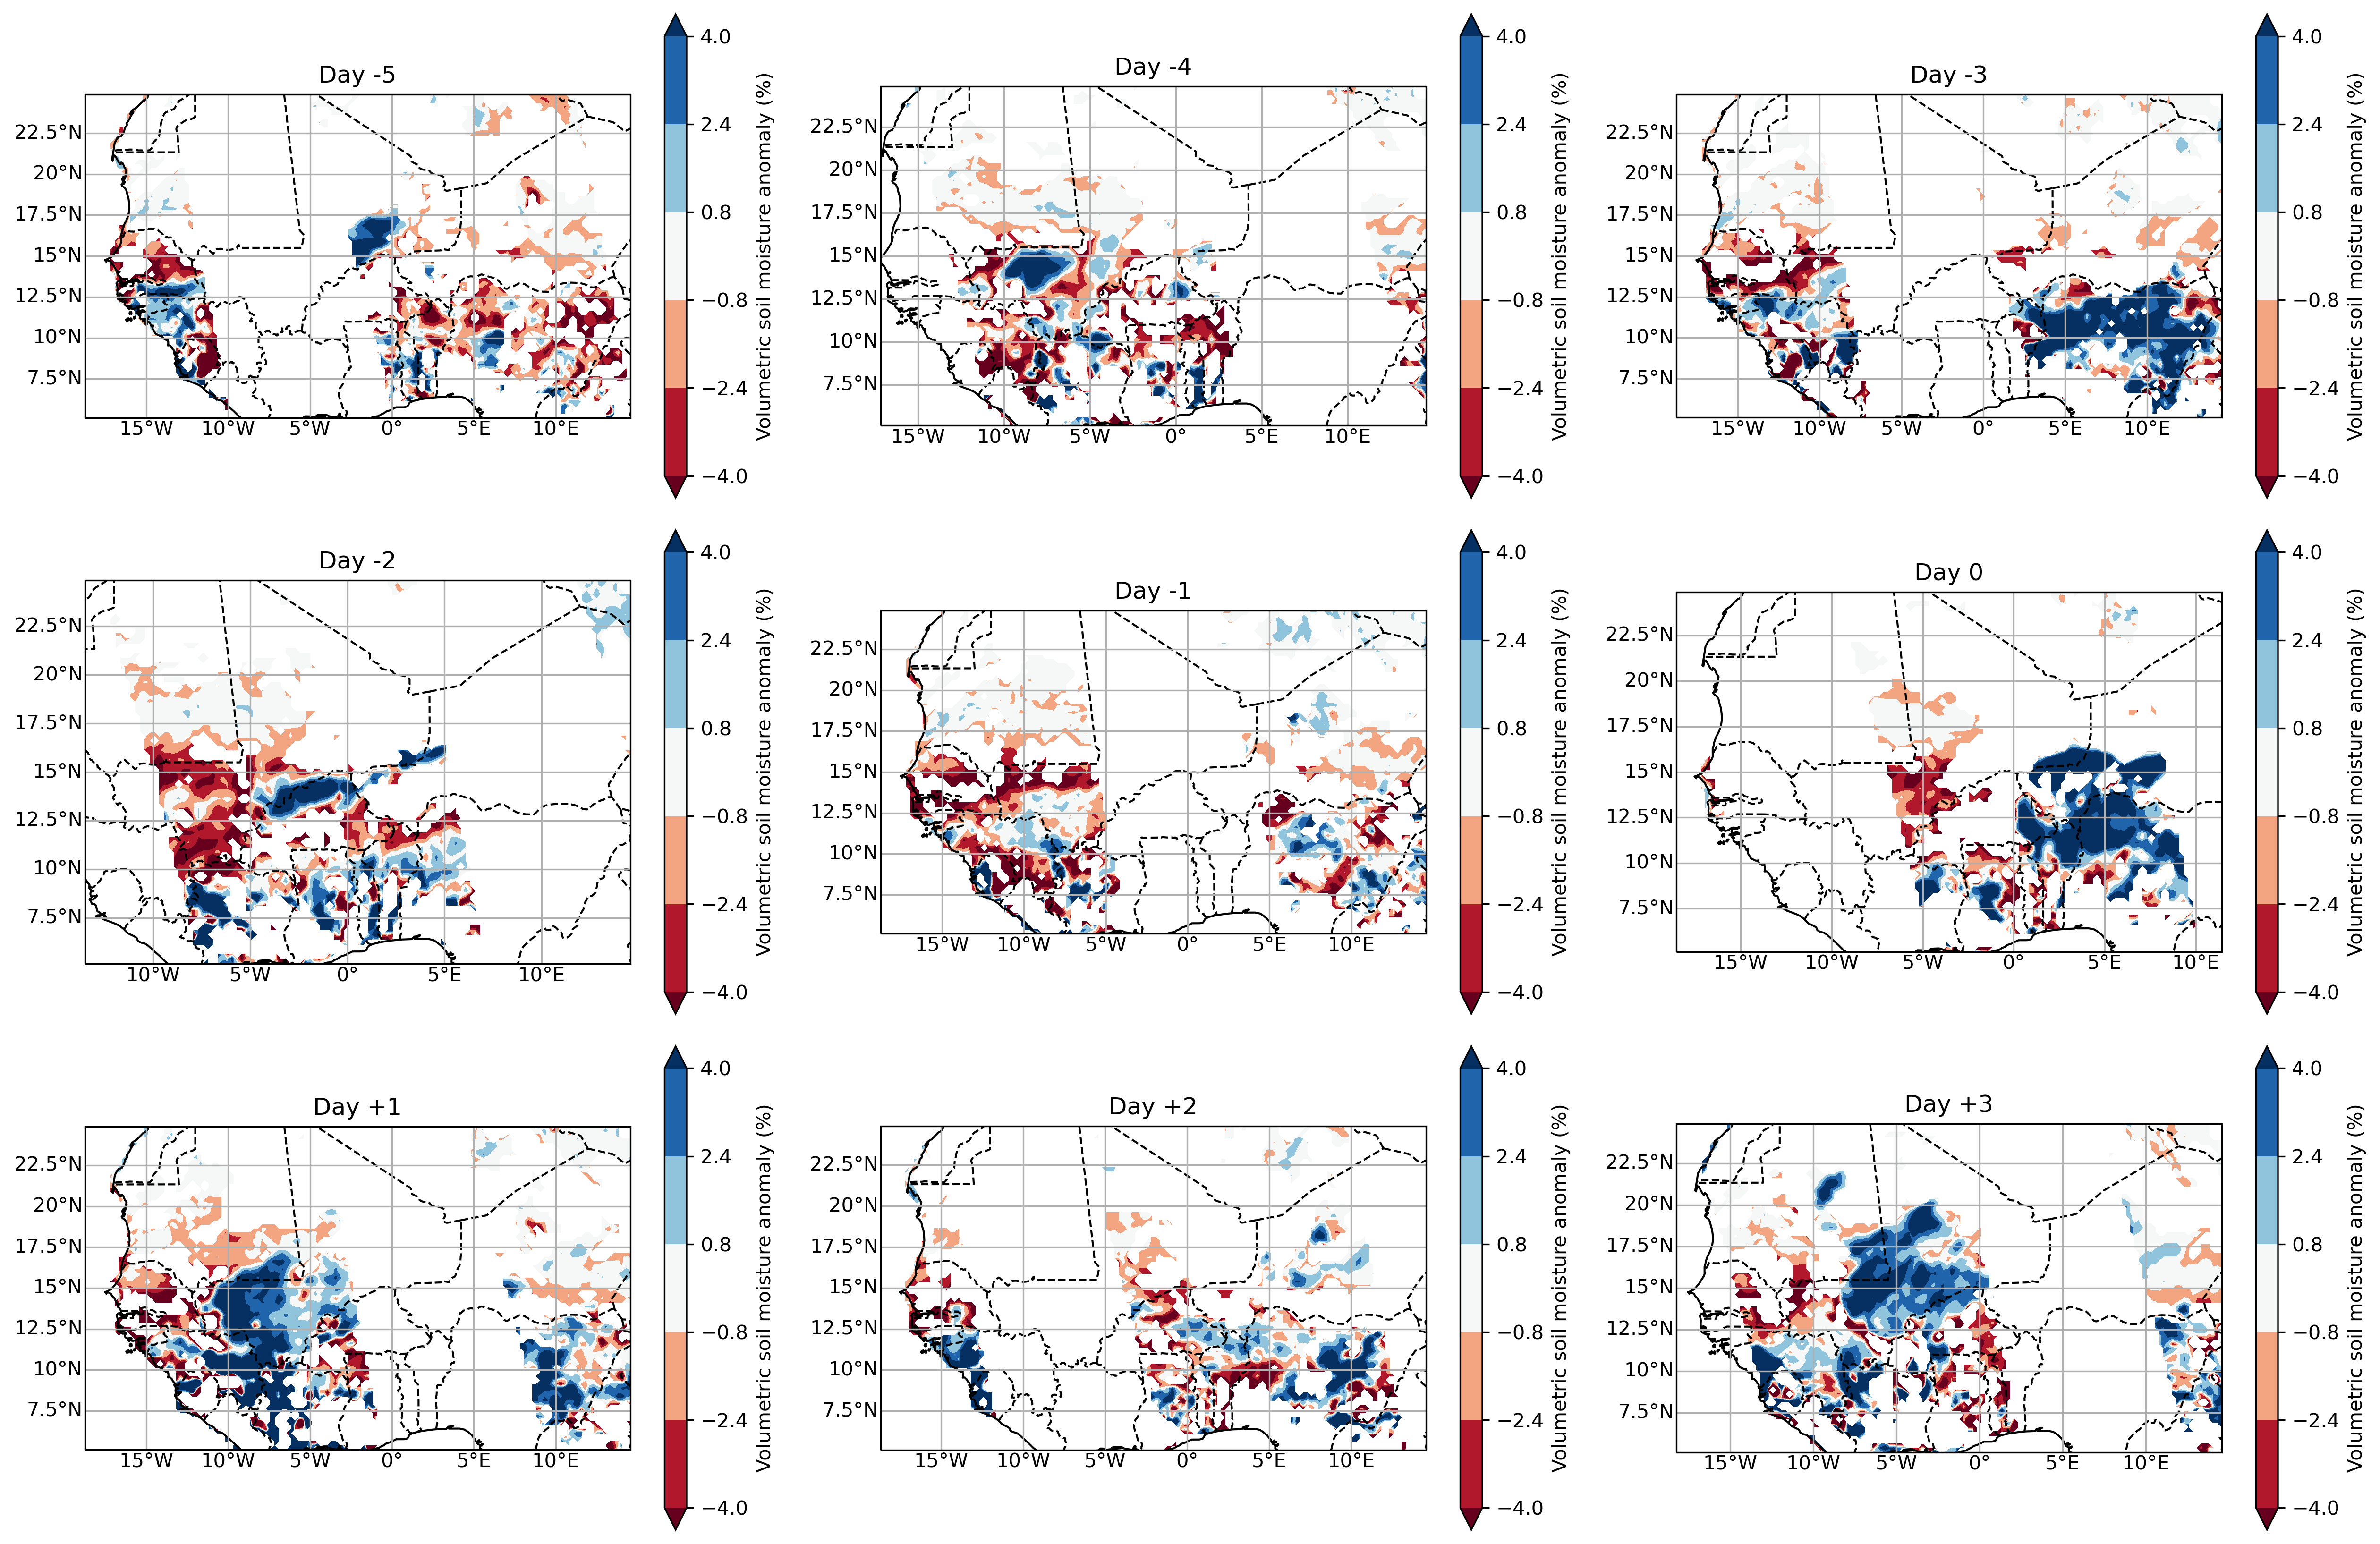

In [92]:
f = plt.figure(figsize=(17,11), dpi=300)

ax = f.add_subplot(331, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run(-5)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Day -5')

ax = f.add_subplot(332, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run(-4)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Day -4')


ax = f.add_subplot(333, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run(-3)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Day -3')

ax = f.add_subplot(334, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run(-2)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Day -2')

ax = f.add_subplot(335, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run(-1)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Day -1')

ax = f.add_subplot(336, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run(0)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Day 0')

ax = f.add_subplot(337, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run(1)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Day +1')

ax = f.add_subplot(338, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run(2)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Day +2')

ax = f.add_subplot(339, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run(3)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Day +3')


f.canvas.draw()
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/NFLICS/NFLICS_SManomaly_dakarstorms.png')

In [97]:
def draw_map(t, lat, lon):
    f=plt.figure(figsize=(8,6), dpi=300)
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())
    plt.contourf(lon-0.4, lat, t, transform=ccrs.PlateCarree(), cmap='viridis', extend='both', levels=np.arange(10,17))
    ax.coastlines()
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    plt.title('')
    cbar = plt.colorbar()
    cbar.set_label('Valid storm cases')
    f.canvas.draw()
    plt.tight_layout()
    
    plt.savefig(cnst.network_data + 'figs/NFLICS/valid_cases.png')
    #plt.show()

In [98]:
def run2(shift, day=True):

    kernel2_list = []
    kernel3_list = []
    cnt_list = []


    for date in tab.time:


        single = tab[tab.time==date]

        dt = pd.to_datetime(date)
        daystring = str(abs(shift))
        dayd = pd.Timedelta(daystring + 'days')
        if shift < 0:
            dt = dt - dayd
        if shift >=0:
            dt = dt + dayd
        
        #ipdb.set_trace()
        fdate = str(dt.year) + str(dt.month).zfill(2) + str(dt.day).zfill(2)
        
        if day:
            fpath = cnst.lmcs_drive + 'AMSR2/daily/25km/day_anom_v2/'
            try:
    
                lsta = xr.open_dataset(fpath + 'amsr2_25km_anom_' + fdate + '.nc') #sma  #'AMSR_L3_LPRMv05_A_'
            except:
                continue

        else:
            fpath = cnst.lmcs_drive + 'AMSR2/daily/25km/night_anom_v2/'
            try:
                lsta = xr.open_dataset(fpath + 'amsr2_25km_anom_' + fdate + '.nc')
            except:
                continue
        

        lsta = lsta.sel(lon=slice(-19,20), lat=slice(4, 25))    
        lsta = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day))




        lsta_da = lsta['soil_moisture_c1'].squeeze()


        print('Storm date', date, shift)
        print('Doing '+ 'AMSR_' + str(dt.year) + str(dt.month).zfill(2) + str(
        dt.day).zfill(2) + '.nc')

        cnt = np.zeros_like(lsta_da.values)
        cnt[np.isfinite(lsta_da.values)] = 1

        kernel2_list.append(lsta_da.values)
        kernel3_list.append(lsta_da.values- np.nanmean(lsta_da.values))
        cnt_list.append(cnt) 

        lat = lsta.lat.values
        lon = lsta.lon.values

    kernel2_sum = np.nansum(np.stack(kernel2_list, axis=0), axis=0)
    kernel3_sum = np.nansum(np.stack(kernel3_list, axis=0), axis=0)
    cnt_sum = np.nansum(np.stack(cnt_list, axis=0), axis=0)
    return kernel2_sum, kernel3_sum, cnt_sum, lsta_da

Storm date 2019-08-05 00:00:00 -2
Doing AMSR_20190803.nc
Storm date 2019-08-05 00:00:00 -2
Doing AMSR_20190803.nc


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  war

Storm date 2019-08-05 00:00:00 -1
Doing AMSR_20190804.nc
Storm date 2019-08-05 00:00:00 -1
Doing AMSR_20190804.nc
Storm date 2019-08-05 00:00:00 0
Doing AMSR_20190805.nc


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top a

Storm date 2019-08-05 00:00:00 0
Doing AMSR_20190805.nc
Storm date 2019-08-05 00:00:00 1
Doing AMSR_20190806.nc
Storm date 2019-08-05 00:00:00 1
Doing AMSR_20190806.nc


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attr

Storm date 2019-08-05 00:00:00 2
Doing AMSR_20190807.nc


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


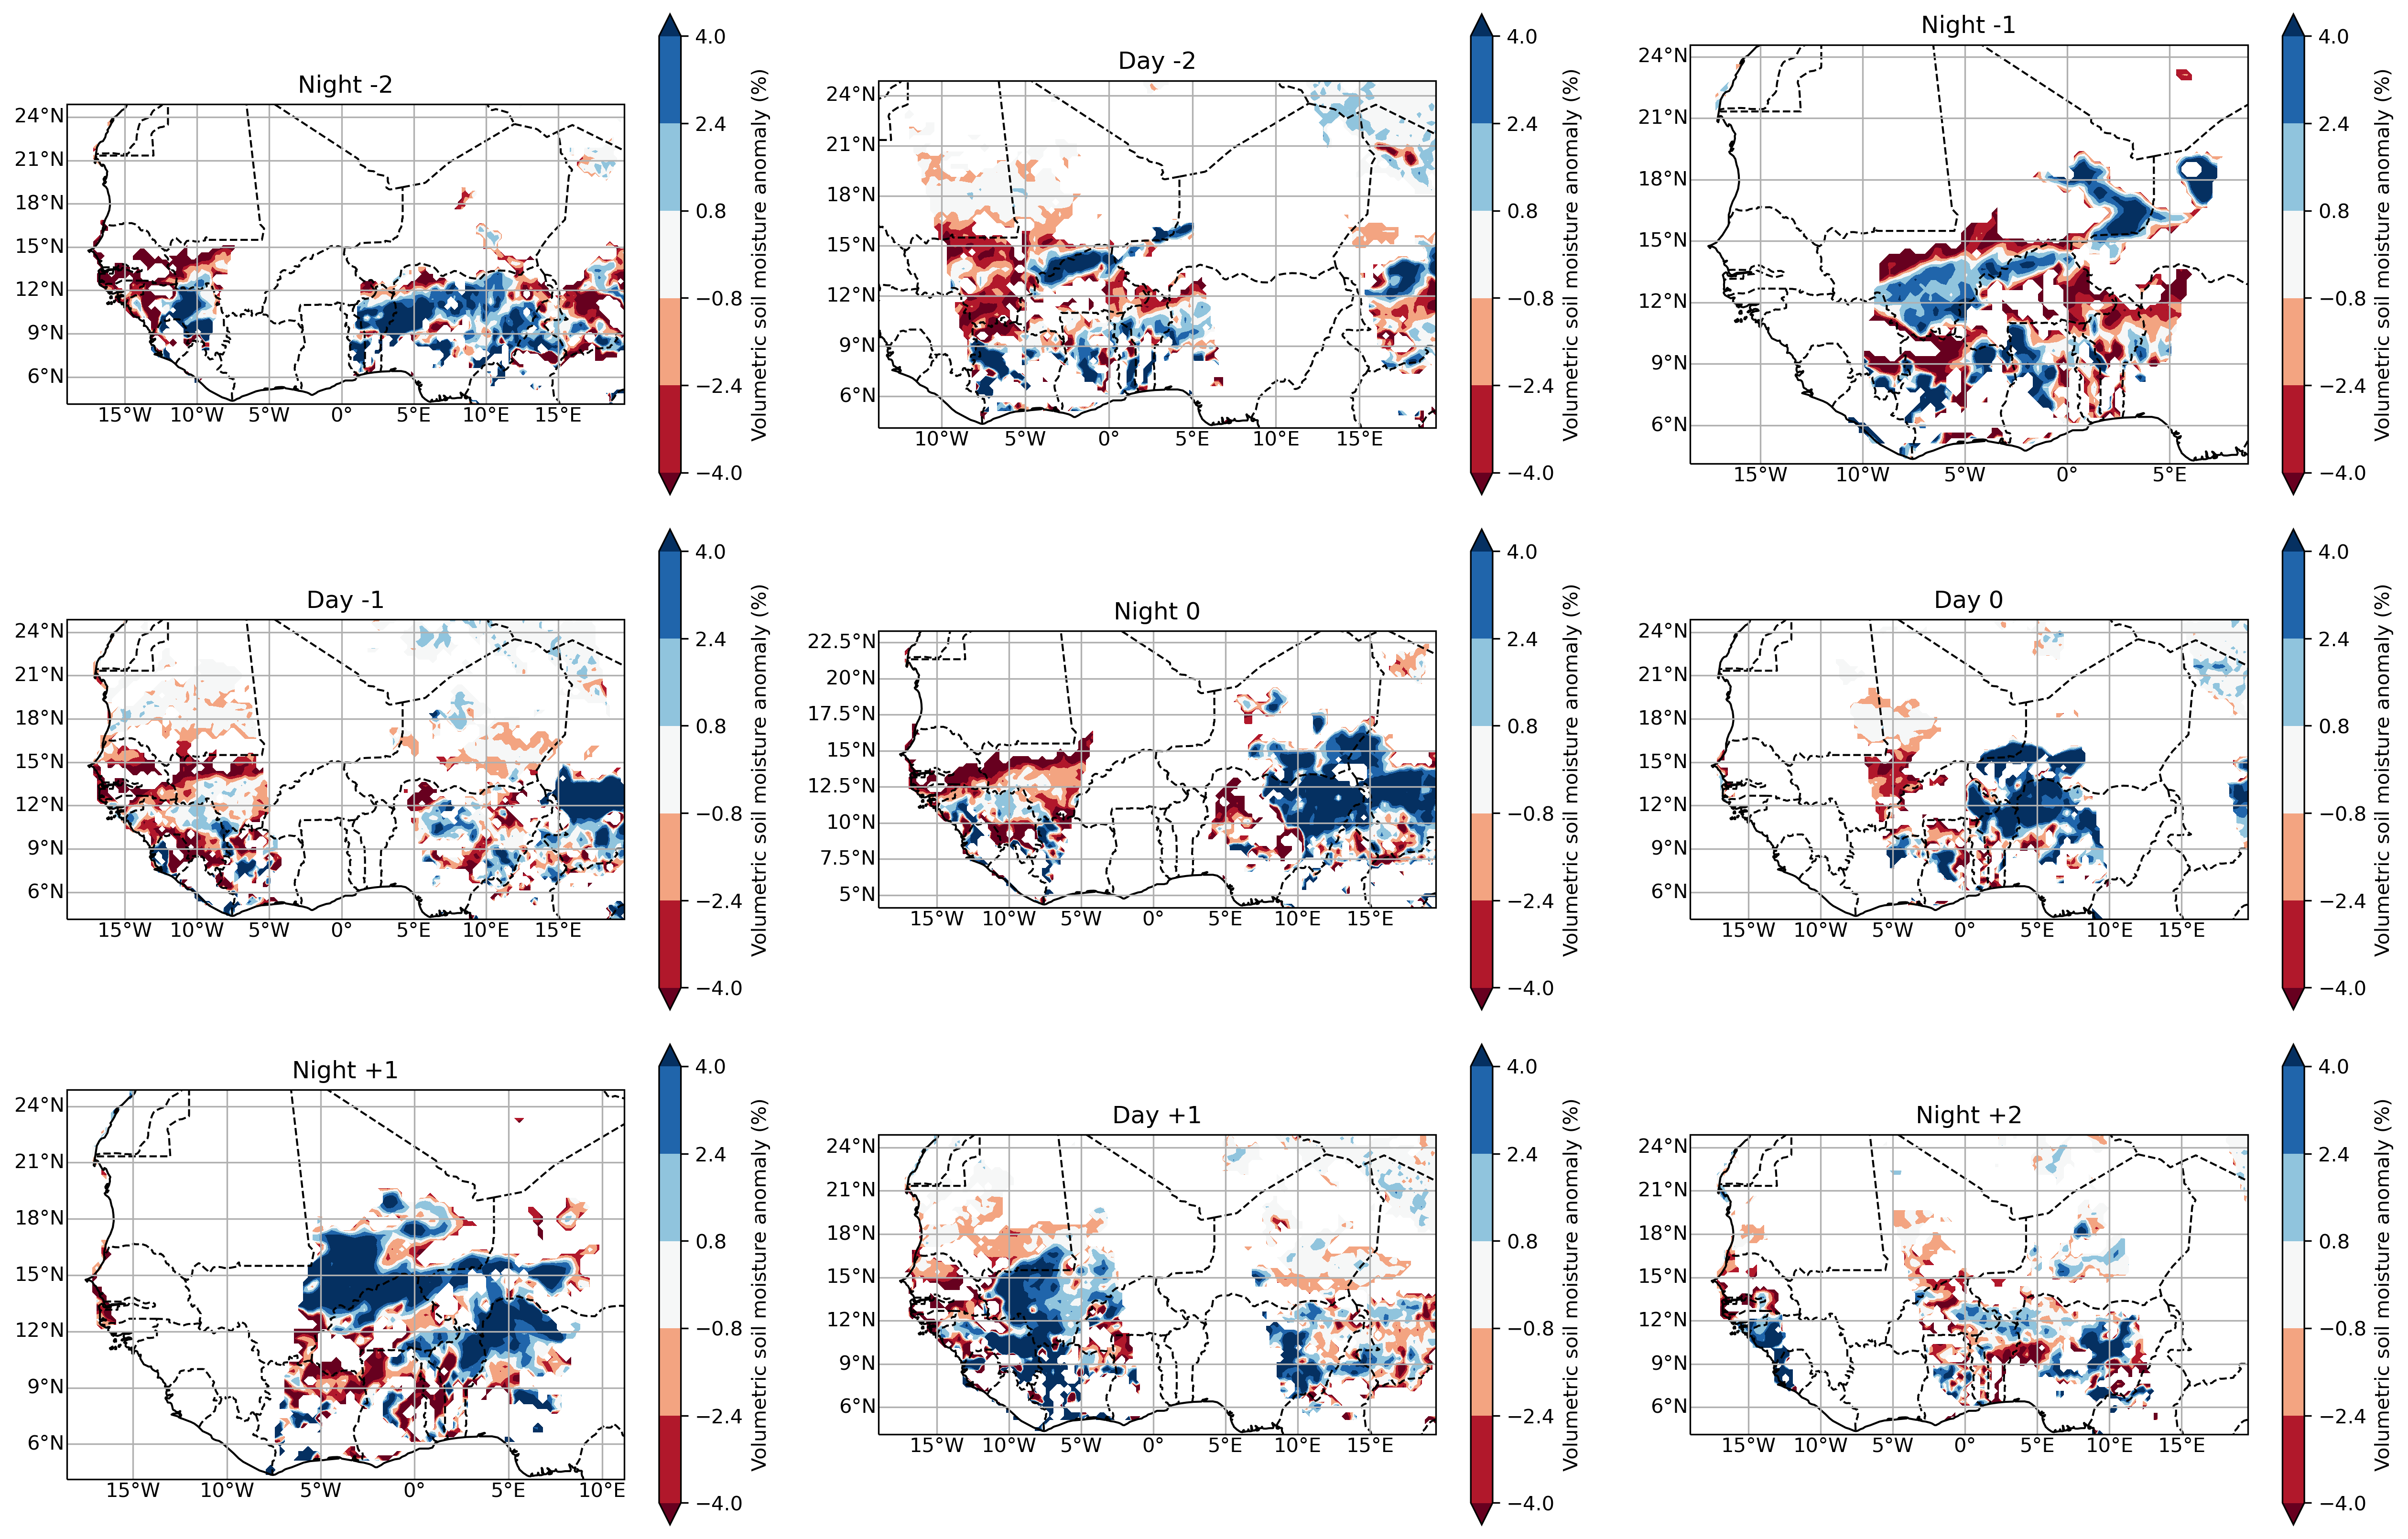

In [101]:
f = plt.figure(figsize=(17,11), dpi=300)

ax = f.add_subplot(331, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run2(-2, day=False)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Night -2')

ax = f.add_subplot(332, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run2(-2)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Day -2')


ax = f.add_subplot(333, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run2(-1, day=False)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Night -1')

ax = f.add_subplot(334, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run2(-1)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Day -1')

ax = f.add_subplot(335, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run2(0, day=False)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Night 0')

ax = f.add_subplot(336, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run2(0)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Day 0')

ax = f.add_subplot(337, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run2(1, day=False)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Night +1')

ax = f.add_subplot(338, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run2(1)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Day +1')

ax = f.add_subplot(339, projection=ccrs.PlateCarree())
ano, regional,cnt, da = run2(+2)
draw_map(ax, ano/cnt, da.lat, da.lon, title='Night +2')


f.canvas.draw()
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/NFLICS/NFLICS_SManomaly_dakarstorms_daynight.png')